## MIE 1624 Assignment #2

### Introduction:

Sentiment Analysis is a type of Natural Language Processing technique that was first developed in text mining. Sentiment Analysis algorithm analyzes a statement or document and determines if the statement is "positive" or "negative". Nowadays, with tremendous amount of texts spreading across various social media platforms, Sentiment Analysis allows companies and politicians to discover trends in public opinion and to use their discoveries to support marketing and campaign activities. 

Tweets posted during the 2019 Canadian election period are collected from the web and stored in the Canadian_elections_2019.csv file. The goal is to use Sentiment Analysis on Tweets collected to gain insights into the 2019 Canadian election. The ultimate question that the analysis should be able to answer is: "What can public opinion on Twitter tell us about the Canadian political landscape in 2019?". The analysis is broken down into the following steps: data cleaning, exploratory analysis, model preparation, model implementation and results. 

### Import libraries:

In [1]:
!pip install wordcloud

In [119]:
import numpy as np
import pandas as pd
import re
import html
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to /Users/Joy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Data Cleaning

The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’. Therefore, the first step is to “clean” the data. Design a procedure that prepares the Twitter data for analysis by satisfying the requirements below.
<br>o All html tags and attributes (i.e., /<[^>]+>/) are removed.
<br>o Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
<br>o All URLs are removed.
<br>o All characters in the text are in lowercase.
<br>o All stop words are removed. Be clear in what you consider as a stop word.
<br>o If a tweet is empty after pre-processing, it should be preserved as such.

Before getting started on the preprocessing, let's import the two sets of data.

In [3]:
# import Sentiment.csv
sentiment_df = pd.read_csv('/Users/Joy/Desktop/Data Science and Analytics/Assignment 2/Sentiment.csv')
sentiment_df.head()

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


In [4]:
# import Canadian_elections_2019.csv 
elections_df = pd.read_csv('/Users/Joy/Desktop/Data Science and Analytics/Assignment 2/Canadian_elections_2019.csv')
elections_df.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


Check if any tweet in the sentiment dataset is empty. If yes, we need to separate rows with empty tweets into another dataframe and preprocess non-empty tweets for now. We will concatenate these two dataframes at the end of preprocessing.

In [5]:
# check if sentiment dataset has nan values in the text column:
sentiment_df.text.isnull().sum()

14

14 rows in the sentiment dataset has empty tweets in the text column. In addition, the sentiment is classified into three categories: positive, negative and neutral. Since the goal of this assignment is to classify tweets into either positive or negative categories, tweets with neutral sentiment will be dropped so that we can develop consistent machine learning models for both datasets. 

In [6]:
# Separate all rows with nan values in the text column into another dataframe:
sentiment_df_nan = sentiment_df[sentiment_df['text'].isnull()]

# Remove all rows with nan values in the text column from sentiment_df:
sentiment_df = sentiment_df.dropna(subset=['text'])
# Drop all rows with 'Neutral' sentiment:
sentiment_df = sentiment_df[sentiment_df.sentiment != 'Neutral']
sentiment_df = sentiment_df.reset_index(drop=True)
#sentiment_df.head()

Since both datasets are collected directly from the web, they are not in a form that is ready for sentiment analysis. In order to prepare the data, we need to perform the following preprocessing steps: removing HTML tags and attributes, replacing HTML character code with an ASCII equivalent, removing URLs, removing special characters and emojis, removing punctuations, transfering to lowercase, remvoing stop words, and steming and tokenizing text.

In order to design a procedure that performs the series of preprocessing work mentioned above, the following lambda functions are defined, each serving one preprocessing purpose. All lambda functions are applied to both datasets.

In [7]:
# Define a function that removes all HTML tags and attributes:
def html_remove(text):
    text = re.sub(r'<[^>]+>', '' , text)
    return text

# Apply the function to both datasets:
sentiment_df['text_clean'] = sentiment_df['text'].apply(html_remove)
elections_df['text_clean'] = elections_df['text'].apply(html_remove)

In [8]:
# Define a function that converts HRML character code to an ASCII equivalent:
def html_char_to_ASCII(text):
    text = html.unescape(text)
    return text

# Apply the function to both datasets:
sentiment_df['text_clean'] = sentiment_df['text_clean'].apply(html_char_to_ASCII)
elections_df['text_clean'] = elections_df['text_clean'].apply(html_char_to_ASCII)

In [9]:
# Define a function that removes urls:
def remove_url(text):
    pattern1 = 'http\S+'
    text = re.sub(pattern1, '', text)
    
    pattern2 = 'www\.\w+\S+'
    text = re.sub(pattern2, '', text)
    return text

# Apply the function to both datasets:
sentiment_df['text_clean'] = sentiment_df['text_clean'].apply(remove_url)
elections_df['text_clean'] = elections_df['text_clean'].apply(remove_url)

Now that we have removed all HTML tags, attributes and urls, and converted HTML character codes to an ASCII equivalent, however, the text still contains noises such as special characters, punctuations, emojis, numbers and stopwords. We need to remove those noises before tokenizing the text. 

In [10]:
# Define a function that removes all special characters and punctuations:
def remove_special_char(text):
    pattern1 = '[^A-Za-z0-9 ]'
    text = re.sub(pattern1, ' ', text)
    
    pattern2 = '[?|$|.|!|@|&]'
    text = re.sub(pattern2, ' ', text)
    return text

# Apply the function to both datasets:
sentiment_df['text_clean'] = sentiment_df['text_clean'].apply(remove_special_char)
elections_df['text_clean'] = elections_df['text_clean'].apply(remove_special_char)

In [11]:
# Define a function that removes all kinds of emojis (emoticons, symbols & pictographs, 
# transport & map symbols, and flags):
def remove_emoji(text):
    pattern1 = '(u"\U0001F600-\U0001F64F"+u"\U0001F300-\U0001F5FF"+u"\U0001F680-\U0001F6FF"+u"\U0001F1E0-\U0001F1FF")'
    text = re.sub(pattern1, '', text)
    
    pattern2 = '(\s)x\w+'
    text = re.sub(pattern2, '', text)
    return text

# Apply the function to both datasets:
sentiment_df['text_clean'] = sentiment_df['text_clean'].apply(remove_emoji)
elections_df['text_clean'] = elections_df['text_clean'].apply(remove_emoji)

Both datasets contain numbers (i.e. 0, 1, 2, 16, ....) or series of numbers (i.e. 00000, 00002, ...) which are not relevant to the purpose of sentiment analysis. In other words, removing numbers from the text should not cause adverse effect on the accuracy of machine learning models that we are developing. In addition, removing numbers will reduce the dimensionality of features for machine learning. The following function is define to remove numbers from the text.

In [12]:
# Define a function that removes all numbers:
def remove_number(text):
    text = re.sub(r'\d+', '', text)
    return text

# Apply the function to both datasets:
sentiment_df['text_clean'] = sentiment_df['text_clean'].apply(remove_number)
elections_df['text_clean'] = elections_df['text_clean'].apply(remove_number)

Before removing stopwords, it is essential to convert all characters to lowercase. 

In [13]:
# Define a function that converts all characters to lowercase:
def lowercase(text):
    text = text.lower()
    return text

# Apply the function to both datasets:
sentiment_df['text_clean'] = sentiment_df['text_clean'].apply(lowercase)
elections_df['text_clean'] = elections_df['text_clean'].apply(lowercase)

The last step in text preprocessing is removing stopwords. A stopword package 'english' is downloaded from the nltk library. One observation that is worth mentioning is that both datasets contain significant amount of rare words that only appear once in the entire dataset. Since they are so rare, the sentiment associated with them cannot be generalized to other text that does not contain such words. Including thoes rare words and fitting them to the model will causes issues such as overfitting. Therefore, rare words should be treated as noises and should be excluded from the cleaned data. On the other hand, frequent words that appear in almost every tweets, no matter it is positive or negative, also do not carry much information regarding the sentiment. These frequent words may not be all captured in the stopwords package, and thus, need to be excluded manually. In order to exclude both rare and frequent words, the word frequency is calculated and is ranked from the highest frquency to the lowest. Only words in the middle range, i.e. ranked between 20 and 2000, will be kept. 

In [14]:
# Calculate the word frequency in the sentiment dataset
# and keep words ranked between 20 and 2000:
shared_sentiment = pd.Series(' '.join(sentiment_df['text_clean']).split()).value_counts()[20:2000]
shared_sentiment = list(shared_sentiment.index)

In [15]:
# Define a function that tokenize the text and removes stopwords, rare words and frequent words as identified above:
def remove_stopwords(text):
    sl = ' '
    tokenizer = RegexpTokenizer(r'\w+')
    b = tokenizer.tokenize(text)         # Tokenize the text
    no_stopwords = [word for word in b if word not in stopwords.words('english')]
    no_stopwords = [word for word in no_stopwords if word in shared_sentiment]
    #ps = PorterStemmer()
    #word_stem = [ps.stem(word) for word in no_stopwords]
    return sl.join(no_stopwords)

# Apply the function the sentiment dataset:
sentiment_df['text_clean'] = sentiment_df['text_clean'].apply(remove_stopwords)

In [16]:
# By inspecting the election dataset, the following words appear frequently in the text
# but do not contain much information regarding the sentiment of the text:
additional_stopwords = ['cdnpoli','onpoli','elxn43','canada','b','n','cndpoli']

In [17]:
# Calculate the word frequency in the election dataset
# and keep words ranked between 20 and 2000:
shared_elections = pd.Series(' '.join(elections_df['text_clean']).split()).value_counts()[20:2000]
shared_elections = list(shared_elections.index)

In [18]:
# Define a function that tokenize the text and removes stopwords, rare words and frequent words as identified above:
def remove_stopwords(text):
    sl = ' '
    tokenizer = RegexpTokenizer(r'\w+')
    b = tokenizer.tokenize(text)         # Tokenize the text
    no_stopwords = [word for word in b if word not in stopwords.words('english') + additional_stopwords]
    no_stopwords = [word for word in no_stopwords if word in shared_elections]
    #ps = PorterStemmer()
    #word_stem = [ps.stem(word) for word in no_stopwords]
    return sl.join(no_stopwords)

# Apply the function to the election dataset:
elections_df['text_clean'] = elections_df['text_clean'].apply(remove_stopwords)

Finally, let's check the cleaned text data.

In [19]:
# Check the cleaned dataset:
sentiment_df.head()

,sentiment,text,text_clean
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,rt realdonaldtrump tried take matter foxnews m...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",damn jealous wanna watch fight love one knows
2,Positive,I'm listening The Beatles now. They're great,listening great
3,Positive,@ddlovato could i please get a shout out or an...,ddlovato could please get shout anything huge ...
4,Positive,@salspizza just spotted ur message there Tony ...,ur message


In [20]:
# Check the cleaned dataset:
elections_df.head()

,sentiment,negative_reason,text,text_clean
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead agree canadian women trust...
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",real station etobicokenorth
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canadaelection canadavotes decide help
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",taxpayers sick tired hard earned corporate nee...


### 2. Exploratory Analysis

Design a simple procedure that determines the political party (Liberal, Conservative, NDP, None) of a given tweet and apply this procedure to all the tweets in the 2019 Canadian elections dataset. A suggestion would be to look at relevant words and hashtags in the tweets that identify to certain political parties. What can you say about the distribution of the political affiliations of the tweets?

In order to design a procedure that determines the political parties associated with all the tweets in the 2019 Canadian election, the following lambda function is defined. Political parties are assigned based on relevant words detected in the text. If relevant words from multiple parties are detected in one tweet, the party that is referred to more frequently will be assigned. The revelant words for each party are defined as follows:
+ **Liberal Party of Canada (LPC):**
<br>  Leader: Justin Trudeau<br>  Slogan: Choose forward


+ **Conservative Party of Canada (CPC):**
<br>  Leader: Andrew Scheer<br>  Slogan: Get ahead


+ **New Democratic Party (NDP):**
<br> Leader: Jagmeet Singh

In [21]:
# Relevant words for each party:
Liberal = ['justintrudeau','justin trudeau','justin','trudeau','liberals','liberal','lpc','choose forward','chooseforward']
Conservative = ['conservatives','conservative','cpc','andrewscheer','andrew scheer','scheer','scheerlies','get ahead']
NDP = ['jagmeet singh','jagmeet','jagmeetsingh','ndp','india']

In [22]:
# Define a function that determines the party that the tweet is affiliated with:
def det_party(text):
    affiliated = []
    for word in Liberal:
        if word in text:
            affiliated.append('Liberal')
            
    for word in Conservative:
        if word in text:
            affiliated.append('Conservative')
            
    for word in NDP:
        if word in text:
            affiliated.append('NDP')
     
    if len(affiliated) > 0:
        set(affiliated)
        party = max(set(affiliated), key = affiliated.count)
    
    else:
        party = 'None'
       
    return party

# Apply the function to the elections_df
# Here we use the cleaned text for determining the party:
elections_df['Parties'] = elections_df['text_clean'].apply(det_party)

In [23]:
elections_df.head()

,sentiment,negative_reason,text,text_clean,Parties
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead agree canadian women trust...,Conservative
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",real station etobicokenorth,None
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...,Liberal
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canadaelection canadavotes decide help,None
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",taxpayers sick tired hard earned corporate nee...,Liberal


In order to explore the distribution of political affiliations of the tweets, we need a bar plot that has the name of the parties as the x-axis and the number of tweets affiliated with each party as the y-axis.

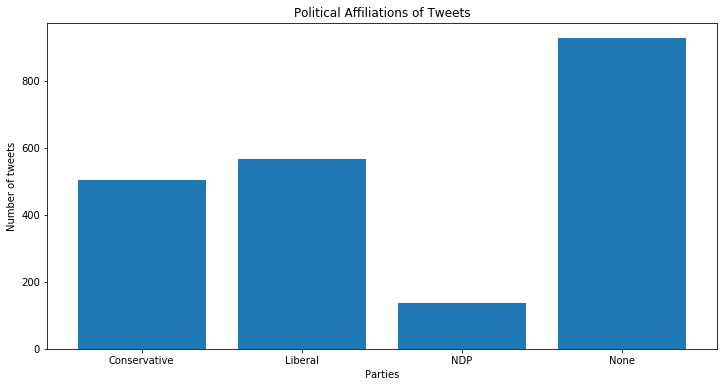

In [24]:
# Set the bar plot:
plt.figure(figsize=(12,6))
x = elections_df.groupby('Parties').count().index
height = elections_df.groupby('Parties').count()['text_clean']
plt.bar(x, height)
plt.xlabel('Parties')
plt.ylabel('Number of tweets')
plt.title('Political Affiliations of Tweets')
plt.show()

It is shown in the bar plot above that a big amount of tweets (around 900) is classified as None, which in fact might be affiliated with other political parties such as the Green Party and the People's Party. Among the other three identified parties, the Liberal party has the highest amount of tweeets, which is around 580. It is followed by the Conservative party which has around 500 tweets. The New Democratic Party has the least amount of tweets which is slightly below 200. It can be concluded that the Conservative and the Liberal received significant more discussion on Tweeter than other parties.

Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc) that visualizes some aspect of the generic tweets from Sentiment.csv file and another figure for the 2019 Canadian election tweets. All graphs and plots should be readable and have all axes that are appropriately labelled.

First of all, we need to explore how many tweets in the Sentiment.csv file are classified as Positive, and how many are classified as Negative.

[Text(0, 0.5, 'Number of tweets'),
 Text(0.5, 0, 'Sentiment'),
 Text(0.5, 1.0, 'Distribution of Sentiment')]

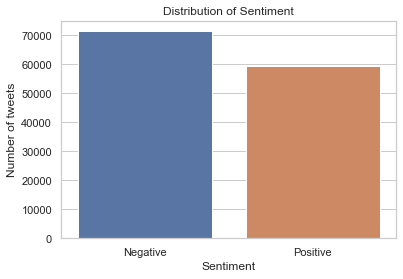

In [25]:
# Create a bar plot that shows the distribution of positive and negative tweets:
sns_plot = pd.DataFrame(data = sentiment_df['sentiment'].value_counts()).reset_index()
sns.set(style="whitegrid")
ax = sns.barplot(x = sns_plot['index'], y = sns_plot['sentiment'])
ax.set(xlabel='Sentiment', ylabel='Number of tweets', title='Distribution of Sentiment')

It is shown in the bar plot above that around 70,000 generic tweets in the dataset are negative tweets. Approximately 60,000 tweets in the dataset are positive tweets. Overall although the nubmer of negative tweets is slightly higher than the number of positive tweets, it still can be considered as a balanced dataset.

### Bonus

Next, it will be interesting to see what kind of words are associated with positive tweets and negative tweets, respectively. However, before that, we could first visualize the most common words in all of the tweets in the form of a word cloud.

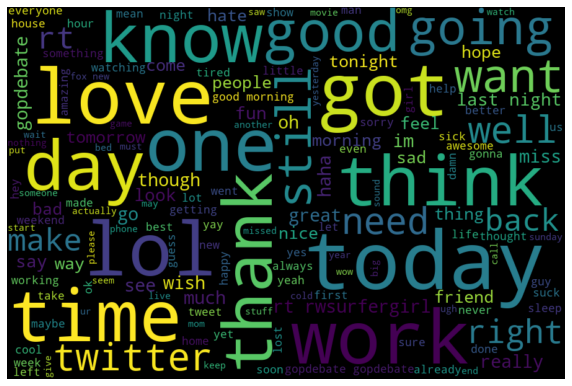

In [26]:
# Create a word cloud that illustrates the most common words in all of the tweets:
all_words = ' '.join(text for text in sentiment_df['text_clean'])
wordcloud =  WordCloud(width=900, height=600, random_state=21, max_font_size=130,max_words=150).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Now we can visualize common words associated with positive tweets, also in the form of a word cloud.

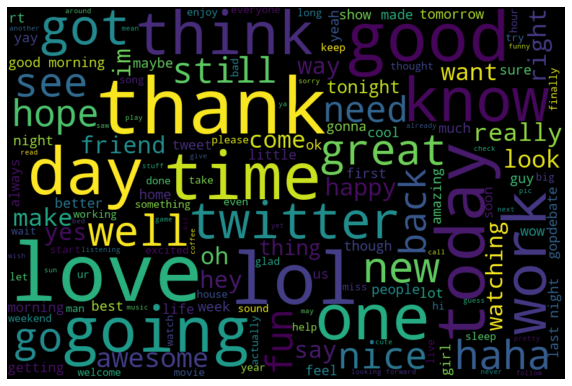

In [27]:
# Creat a wordcloud that illustrate the most common words in positive tweets:
all_positive = ' '.join(text for text in sentiment_df.loc[sentiment_df['sentiment']=='Positive']['text_clean'])
wordcloud =  WordCloud(width=900, height=600, random_state=21, max_font_size=130, max_words=150).generate(all_positive)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Words 'thank', 'love', 'well', 'good', 'great' and etc. are associated with positive sentiment.

What about tweets that are classified as negative?

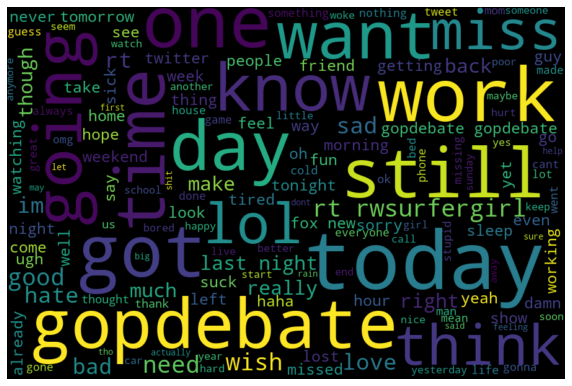

In [28]:
# Create a word cloud that illustrates the most common words in negative tweets:
all_negative = ' '.join(text for text in sentiment_df.loc[sentiment_df['sentiment']=='Negative']['text_clean'])
wordcloud =  WordCloud(width=900, height=600, random_state=21, max_font_size=130, max_words=150).generate(all_negative)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Words 'gopdebate', 'today', 'work' 'time', 'still' and etc. are often related to negative sentiment.

Now that we have done some exploration on the sentiment data, we can duplicate the same exercies on the 2019 Canadian election data. First, we can plot the distribution of sentiment in the 2019 Canadian election dataset.

[Text(0, 0.5, 'Number of tweets'),
 Text(0.5, 0, 'Sentiment'),
 Text(0.5, 1.0, 'Distribution of Sentiment')]

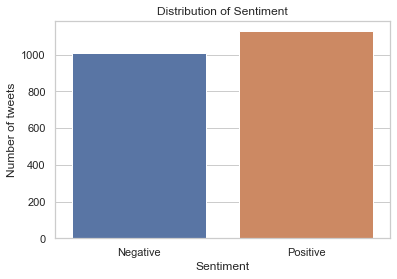

In [29]:
# Creat a bar plot that illustrates the distribution of sentiment in the 2019 Canadian election data:
sns.set(style="whitegrid")
ax = sns.countplot(x="sentiment", data=elections_df)
ax.set(xlabel='Sentiment', ylabel='Number of tweets', title='Distribution of Sentiment')

It is shown in the bar plot above that 1,000 tweets are negative and 1,100 tweets are positive. It is a fairly balanced dataset.

However, to better answer the research question proposed at the beginning of the report, we are more interested in the sentiment distribution of tweets in each party. A bar plot that illustrates that is presented below.

[Text(0, 0.5, 'Number of tweets'),
 Text(0.5, 0, 'Party'),
 Text(0.5, 1.0, 'Distribution of Sentiment')]

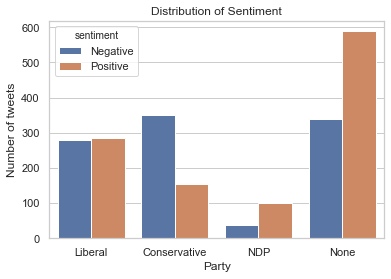

In [30]:
# Create a bar plot that illustrate the distribution of sentiment in each party:
sns.set(style="whitegrid")
ax = sns.countplot(x='Parties', hue="sentiment", data=elections_df, order=['Liberal','Conservative','NDP','None'])
ax.set(xlabel='Party', ylabel='Number of tweets', title='Distribution of Sentiment')

It is clear that the Conservative party received more negative tweets (350 tweets) comparing to other parties, and even more negative tweets than positive tweets (150 tweets) for the Conservative. The Liberal party had a fair distribution between positive and negative tweets, both around 280 tweets. The NDP received a lot more postive tweets (100 tweets) than negative tweets (30 tweets). Among the three parties, the Liberal had the most postive tweets, and the Conservative had the most negative tweets. This result is somehow consistent with the election outcome in 2019 where the Liberal won the election.

### Bonus

To have closer look at the negative reasons for each party, we can visualize the distribution of negative reasons as follows:

[Text(0, 0.5, 'Number of tweets'),
 Text(0.5, 0, 'Parties'),
 Text(0.5, 1.0, 'Distribution of Negative Reasons')]

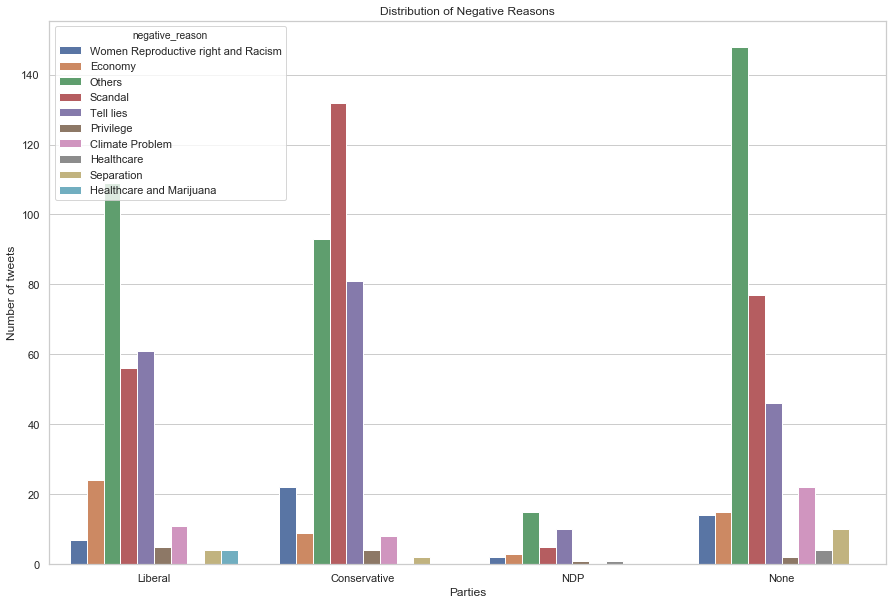

In [231]:
# Create a bar plot that illustrates the distribution of negative reasons for each party:
sns.set(style="whitegrid", rc={'figure.figsize':(15,10)})
ax = sns.countplot(x='Parties', hue="negative_reason", data=elections_df, order=['Liberal','Conservative','NDP','None'])
ax.set(xlabel='Parties', ylabel='Number of tweets', title='Distribution of Negative Reasons')

It can be concluded that the top three negative reasons for all parties ara: others, scandal and tell lies.

Lastly, we can visualize top words affiliated with the Liberal, the Conservative and the NDP, respectively, in the form of word clouds.

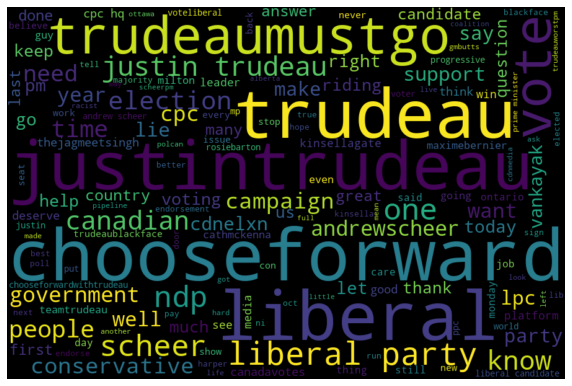

In [31]:
# Create word cloud that illustrates the common words associated with the Liberal:
all_liberals = ' '.join(text for text in elections_df.loc[elections_df['Parties']=='Liberal']['text_clean'])
wordcloud =  WordCloud(width=900, height=600, random_state=21, max_font_size=130, max_words=150).generate(all_liberals)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Words such as 'justin trudeau', 'choose forward', 'liberal', 'trudeaumustgo' appear the most frequently in tweets affiliated with the Liberal.

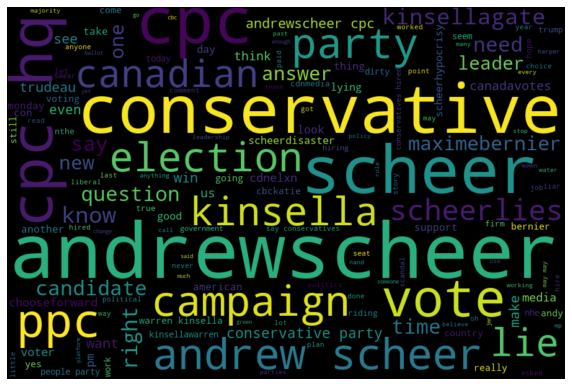

In [32]:
# Create word cloud that illustrates the common words associated with the Conservative:
all_conservatives = ' '.join(text for text in elections_df.loc[elections_df['Parties']=='Conservative']['text_clean'])
wordcloud =  WordCloud(width=900, height=600, random_state=21, max_font_size=130, max_words=150).generate(all_conservatives)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Words such as 'andrew scheer', 'conservative', 'kinsella', 'campaign' appear the most frequently in tweets affiliated with the Conservative.

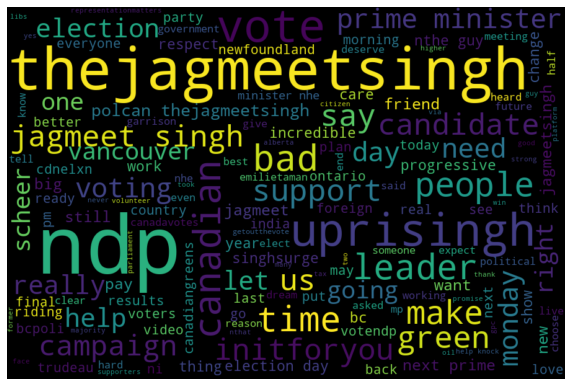

In [33]:
# Create word cloud that illustrates the common words associated with the NDP:
all_ndps = ' '.join(text for text in elections_df.loc[elections_df['Parties']=='NDP']['text_clean'])
wordcloud =  WordCloud(width=900, height=600, random_state=21, max_font_size=130, max_words=150).generate(all_ndps)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Words such as 'jagmeet singh', 'ndp', 'uprisingh', 'support', 'leader' appear the most frequently in tweets affiliated with the NDP.

### 3. Model Preparation

Split the generic tweets from Sentiment.csv file randomly into training data (70%) and test data (30%). Prepare the data to try multiple classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost)), where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, word frequency (WF) and TF-IDF.

When fitting a machine learning model to a training dataset with ovver 100,000 obeservations, the computation time tends to be extreme. Since we have more than enough obeservations, we can sample a portion of the entire population, which will reduce the training and testing data size effectively. To speed up computation without sacrificing machine learning model performance, 7500 observations will be sampled. It is critical to ensure that the dataset is still balanced after sampling. 

In [34]:
# Separate positive and negative classes:
sentiment_df_positive = sentiment_df[sentiment_df.sentiment=='Positive']
sentiment_df_negative = sentiment_df[sentiment_df.sentiment=='Negative']
 
# Sample positive class:
positive_sampled = resample(sentiment_df_positive, replace=False, n_samples=3750,random_state=20) 
 
# Sample negative class:
negative_sampled = resample(sentiment_df_negative, replace=False, n_samples=3750,random_state=20) 
  
# Combine positive class with negative class:
sentiment_sampled = pd.concat([positive_sampled, negative_sampled])
 
# Display new class counts
sentiment_sampled.sentiment.value_counts()

Positive    3750
Negative    3750
Name: sentiment, dtype: int64

We have sampled 3750 generic positive tweets and 3750 generic negative tweets from the original sentiment dataset.

Now that we have cleaned and tokenized words in the tweets, we are ready to extract features for natural language processing from the cleaned tweets. Depending on the purpose, text features can be extracted using two methods: word frequency (WF) and Term Frequency - Inverse Document Frequency (TF-IDF). 

Method 1: Word Frequency

In [35]:
# Create WF for the sentiment dataset:
vectorizer = CountVectorizer()
array_WF = vectorizer.fit_transform(sentiment_sampled['text_clean']).toarray()
#print(vectorizer.vocabulary_)
#print(vectorizer.get_feature_names())
array_WF.shape

(7500, 1846)

In [36]:
# Store the word frequency in a dataframe:
# Each column of the dataframe represents one feature for machine learning:
X_WF_sentiment = pd.DataFrame(data=array_WF, columns=vectorizer.get_feature_names())
X_WF_sentiment.head()

,able,abortion,absolutely,abt,account,ache,across,act,actually,adam,...,yo,york,young,youre,youtube,yr,yrs,yum,yummy,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Create WF for the elections dataset:
vectorizer2 = CountVectorizer()
array_WF2 = vectorizer2.fit_transform(elections_df['text_clean']).toarray()
#print(vectorizer.vocabulary_)
#print(vectorizer.get_feature_names())
array_WF2.shape

(2133, 1846)

In [38]:
# Store the word frequency in a dataframe:
# Each column of the dataframe represents one feature for machine learning:
X_WF_elections = pd.DataFrame(data=array_WF2, columns=vectorizer2.get_feature_names())
X_WF_elections.head()

,ab,abc,able,ableg,abortion,abpoli,absolute,absolutely,abuse,accept,...,york,young,younger,youth,yqg,yr,yrs,yup,yyc,zero
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Method 2: TF-IDF

In [39]:
# Create TF-IDF for the sentiment dataset:
vectorizer1 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
array_TFIDF = vectorizer1.fit_transform(sentiment_sampled['text_clean']).toarray()
#print( vectorizer1.get_feature_names() )
array_TFIDF.shape

(7500, 1846)

In [40]:
# Store the word frequency in a dataframe:
# Each column of the dataframe represents one feature for machine learning:
X_TFIDF_sentiment = pd.DataFrame(data=array_TFIDF, columns=vectorizer1.get_feature_names())
X_TFIDF_sentiment.head()

,able,abortion,absolutely,abt,account,ache,across,act,actually,adam,...,yo,york,young,youre,youtube,yr,yrs,yum,yummy,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Create TF-IDF for the elections dataset:
vectorizer3 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
array_TFIDF3 = vectorizer3.fit_transform(elections_df['text_clean']).toarray()
array_TFIDF3.shape

(2133, 1846)

In [42]:
# Store the word frequency in a dataframe:
# Each column of the dataframe represents one feature for machine learning:
X_TFIDF_elections = pd.DataFrame(data=array_TFIDF3, columns=vectorizer3.get_feature_names())
X_TFIDF_elections.head()

,ab,abc,able,ableg,abortion,abpoli,absolute,absolutely,abuse,accept,...,york,young,younger,youth,yqg,yr,yrs,yup,yyc,zero
0,0.0,0.0,0.0,0.0,5.721314,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Between the two types of features that we developed, TF-IDF features will be used in the following sections as the inputs to machine learning models because TF-IDF is more robust than WF. The IDF term in the TF-IDF model compensates the rarity problem in the WF model.

For the sentiment analysis, our target variable is the sentiment. It is stored in the sentiment column in both datasets. For machine learning purposes, we will encode the categorical target variable and store it in variable y. 

In [43]:
# Generate and encode the target variable for the sentiment dataset:
y_sentiment = sentiment_sampled['sentiment'].astype('category')
y_sentiment = y_sentiment.cat.codes

In [44]:
# Generate and encode the target variable for the elections dataset:
y_elections = elections_df['sentiment'].astype('category')
y_elections = y_elections.cat.codes

In [45]:
# Train test split sentiment dataset (30% testing data):
X_sentiment_train, X_sentiment_test, y_sentiment_train, y_sentiment_test = train_test_split(X_TFIDF_sentiment, y_sentiment, test_size=0.3, random_state = 2)

In [47]:
X_sentiment_train.shape

(5250, 1846)

### 4. Model Implementation

For data from Sentiment.csv file, train models on the training data, tune the hyperparameters (if necessary, with cross-validation) and apply the model to the test data to obtain an accuracy value. Evaluate the same model with best performance on the 2019 Canadian elections data. How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?

Model 1: Logistic Regression

In [49]:
# Train the logistic regression model on training sentiment dataset:
model_lr = LogisticRegression(penalty = 'l2', C = 1, solver = 'saga', max_iter = 2000)
model_lr.fit(X_sentiment_train, y_sentiment_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
# Fine tune hyperparameters
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
#C = np.logspace(0, 4, 10)

# Create regularization solver space
solver = ['liblinear','saga']

# Set the maximum number of iteration to ensure convergence
max_iter = [2000]

# Create hyperparameter options
hyperparameters = dict(penalty=penalty, solver=solver, max_iter=max_iter)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(model_lr, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model_lr = clf.fit(X_sentiment_train, y_sentiment_train)

# View best hyperparameters
print('Best Penalty:', best_model_lr.best_estimator_.get_params()['penalty'])
#print('Best C:', best_model_lr.best_estimator_.get_params()['C'])
print('Best solver:', best_model_lr.best_estimator_.get_params()['solver'])

# Predict target vector
pred_lr = best_model_lr.predict(X_sentiment_test)

Best Penalty: l1
Best solver: saga


In [53]:
print("Accuracy: ", accuracy_score(y_sentiment_test, pred_lr))

Accuracy:  0.6804444444444444


In [55]:
print(classification_report(y_sentiment_test, pred_lr))

              precision    recall  f1-score   support

           0       0.68      0.69      0.68      1123
           1       0.69      0.67      0.68      1127

    accuracy                           0.68      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.68      0.68      0.68      2250



Model 2: K Nearest Neighbours

In [56]:
model_knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
model_knn.fit(X_sentiment_train, y_sentiment_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [59]:
# Fine tune hyperparameters
# Create number of nearest neighbors
n_neighbors = range(3,16)

# Create  weights hyperparameter space
weights = ['uniform','distance']

# Create algorithm hyperparameter space
algorithm = ['ball_tree','kd_tree','brute','auto']

# Create hyperparameter options
hyperparameters = dict(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)

# Create grid search using 5-fold cross validation
clf_knn = GridSearchCV(model_knn, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model_knn = clf_knn.fit(X_sentiment_train, y_sentiment_train)

# View best hyperparameters
print('Best n_neighbors:', best_model_knn.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', best_model_knn.best_estimator_.get_params()['weights'])
print('Best algorithm:', best_model_knn.best_estimator_.get_params()['algorithm'])

# Predict target vector
pred_knn = best_model_knn.predict(X_sentiment_test)

Best n_neighbors: 12
Best weights: uniform
Best algorithm: ball_tree


In [60]:
print("Accuracy: ", accuracy_score(y_sentiment_test, pred_knn))

Accuracy:  0.6333333333333333


In [62]:
print(classification_report(y_sentiment_test, pred_knn))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59      1123
           1       0.61      0.74      0.67      1127

    accuracy                           0.63      2250
   macro avg       0.64      0.63      0.63      2250
weighted avg       0.64      0.63      0.63      2250



Model 3.1: Gaussian Naive Bayes

In [63]:
# Create Gaussian Naive Bayes model:
model_gnb = GaussianNB()
model_gnb.fit(X_sentiment_train, y_sentiment_train)

GaussianNB(priors=None, var_smoothing=1e-09)

There is not much hyperparameter tuning available with the GaussianNB model,thus, we will directly predict the testing data using the model developed above. 

In [64]:
# Predict the target variable:
pred_gnb = model_gnb.predict(X_sentiment_test)

In [65]:
print("Accuracy: ", accuracy_score(y_sentiment_test, pred_gnb))

Accuracy:  0.612


In [66]:
print(classification_report(y_sentiment_test, pred_gnb))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59      1123
           1       0.61      0.74      0.67      1127

    accuracy                           0.63      2250
   macro avg       0.64      0.63      0.63      2250
weighted avg       0.64      0.63      0.63      2250



Model 3.2: Multinomial Naive Bayes

In [156]:
# Create Multinominal Naive Bayes model:
model_mnb = MultinomialNB()
model_mnb.fit(X_sentiment_train, y_sentiment_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

There is not much hyperparameter tuning available with the GaussianNB model,thus, we will directly predict the testing data using the model developed above.

In [157]:
# Predict the target variable:
pred_mnb = model_mnb.predict(X_sentiment_test)

In [158]:
print("Accuracy: ", accuracy_score(y_sentiment_test, pred_mnb))

Accuracy:  0.6982222222222222


In [159]:
print(classification_report(y_sentiment_test, pred_mnb))

              precision    recall  f1-score   support

           0       0.68      0.73      0.71      1123
           1       0.71      0.66      0.69      1127

    accuracy                           0.70      2250
   macro avg       0.70      0.70      0.70      2250
weighted avg       0.70      0.70      0.70      2250



Model 4: Support Vector Machine

In [100]:
# Create Linear Support Vector Classifier:
model_svm = LinearSVC(random_state=2, tol=1e-5, max_iter=50000, dual=False)
model_svm.fit(X_sentiment_train, y_sentiment_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=50000,
          multi_class='ovr', penalty='l2', random_state=2, tol=1e-05,
          verbose=0)

In [107]:
# Fine tune hyperparameters
# Set the penalty to L2
penalty = ['l2']

# Set the loss function to squared hinge
loss = ['squared_hinge']

# Create C hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, loss=loss)

# Create grid search using 5-fold cross validation
clf_svm = GridSearchCV(model_svm, hyperparameters, cv=5, verbose=0,error_score='raise')

# Fit grid search
best_model_svm = clf_svm.fit(X_sentiment_train, y_sentiment_train)

# View best hyperparameters
print('Best C:', best_model_svm.best_estimator_.get_params()['C'])
#print('Best penalty:', best_model_svm.best_estimator_.get_params()['penalty'])
#print('Best loss:', best_model_svm.best_estimator_.get_params()['loss'])

# Predict target vector
pred_svm = best_model_svm.predict(X_sentiment_test)

Best C: 1.0


In [108]:
print("Accuracy: ", accuracy_score(y_sentiment_test, pred_svm))

Accuracy:  0.66


In [109]:
print(classification_report(y_sentiment_test, pred_svm))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59      1123
           1       0.61      0.74      0.67      1127

    accuracy                           0.63      2250
   macro avg       0.64      0.63      0.63      2250
weighted avg       0.64      0.63      0.63      2250



Model 5: Decision Trees

In [112]:
# Create Desicion Tree Classifier:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_sentiment_train, y_sentiment_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [115]:
# Fine tune hyperparameters
# Create criterion hyperparameter space
criterion = ['gini', 'entropy']

# Create splitter hyperparameter space
splitter = ['best', 'random']

# Create max_depth hyperparameter space
max_depth = np.linspace(1, 32, 32, endpoint=True)

# Create min_samples_split hyperparameter space
#min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)

# Create hyperparameter options
hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth)
                       
# Create grid search using 5-fold cross validation
clf_dt = GridSearchCV(model_dt, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model_dt = clf_dt.fit(X_sentiment_train, y_sentiment_train)

# View best hyperparameters
print('Best criterion:', best_model_dt.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model_dt.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_model_dt.best_estimator_.get_params()['max_depth'])
#print('Best min_samples_split:', best_model_dt.best_estimator_.get_params()['min_samples_split'])

# Predict target vector
pred_dt = best_model_dt.predict(X_sentiment_test)

Best criterion: entropy
Best splitter: best
Best max_depth: 32.0


In [116]:
print("Accuracy: ", accuracy_score(y_sentiment_test, pred_dt))

Accuracy:  0.624


In [117]:
print(classification_report(y_sentiment_test, pred_dt))

              precision    recall  f1-score   support

           0       0.76      0.36      0.49      1123
           1       0.58      0.89      0.70      1127

    accuracy                           0.62      2250
   macro avg       0.67      0.62      0.59      2250
weighted avg       0.67      0.62      0.59      2250



Model 6: Random Forest

In [138]:
# Create Random Forest Classifier:
model_rf = RandomForestClassifier(n_estimators=60, max_depth=30, max_features=0.6, random_state=0)
model_rf.fit(X_sentiment_train, y_sentiment_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features=0.6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [135]:
# Fine tune hyperparameters
# Set criterion to entropy
criterion = ['entropy']

# Create n_estimators hyperparameter space
n_estimators = range(30, 70, 5) 

# Create max_depth hyperparameter space
max_depth = np.linspace(1, 42, 42, endpoint=True)

# Create max_features hyperparameter space
max_features = np.linspace(0.1, 0.8, 8, endpoint=True)

# Create hyperparameter options
hyperparameters = dict(criterion=criterion, n  _estimators=n_estimators, max_depth=max_depth, max_features=max_features)

# Create grid search using 5-fold cross validation
clf_rf = GridSearchCV(model_rf, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model_rf = clf_rf.fit(X_sentiment_train, y_sentiment_train)

# View best hyperparameters
print('Best n_estimators:', best_model_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model_rf.best_estimator_.get_params()['max_depth'])
print('Best max_features:', best_model_rf.best_estimator_.get_params()['max_features'])

# Predict target vector
pred_rf = best_model_rf.predict(X_sentiment_test)

In [139]:
pred_rf = model_rf.predict(X_sentiment_test)

In [140]:
print("Accuracy: ", accuracy_score(y_sentiment_test, pred_rf))

Accuracy:  0.6773333333333333


In [141]:
print(classification_report(y_sentiment_test, pred_rf))

              precision    recall  f1-score   support

           0       0.76      0.52      0.62      1123
           1       0.64      0.83      0.72      1127

    accuracy                           0.68      2250
   macro avg       0.70      0.68      0.67      2250
weighted avg       0.70      0.68      0.67      2250



Six classification models are developed to analyze the sentiment associated with sample generic tweets. The accuracy level of each model is summarized as follows:

<table>
    <thead>
        <tr>
            <th>Classification Models</th>
            <th>Accuracy</th>
        </tr>
    <thead>
    <tbody>
        <tr>
            <td>Logistic Regression</td>
            <td>0.680</td>
        </tr>
        <tr>
            <td>K Nearest Neighbours</td>
            <td>0.633</td>
        </tr>
        <tr>
            <td>Gaussian Naive Bayes</td>
            <td>0.612</td>
        </tr>
        <tr>
            <td>Multinomial Naive Bayes</td>
            <td>0.698</td>
        </tr>
        <tr>
            <td>Support Vector Machine</td>
            <td>0.660</td>
        </tr>
        <tr>
            <td>Decision Trees</td>
            <td>0.624</td>
        </tr>
        <tr>
            <td>Random Forest</td>
            <td>0.677</td>
        </tr>
    </tbody>
</table>

Among the 6 classification models that we trained, Multinomial Naive Bayes has the highest accuracy level. Therefore, we will evaluate the same Multinomial Naive Bayes model on the 2019 Canadian elections data.

In [173]:
# Predit the target variable sentiment using 2019 elections data:
pred_elections = model_mnb.predict(X_TFIDF_elections)

In [174]:
print("Accuracy: ", accuracy_score(y_elections, pred_elections))

Accuracy:  0.49132676980778245


In [176]:
print(classification_report(y_elections, pred_elections))

              precision    recall  f1-score   support

           0       0.46      0.48      0.47      1006
           1       0.52      0.50      0.51      1127

    accuracy                           0.49      2133
   macro avg       0.49      0.49      0.49      2133
weighted avg       0.49      0.49      0.49      2133



The accuracy of the Multinomial Naive Bayes model when predicting with the 2019 elections data is 0.491. That means 49.1% of the predicted sentiment agrees with the true sentiment labeled in the dataset. There is a significant drop in the accurcy (from 0.698 to 0.491) when we change the testing dataset from sentiment dataset to elections dataset. This implies the model that we developed and trained does not generalize that well onto unseen data.

Logistic Regression model has almost the same level of accuracy compared to Multinomial Naive Bayes when testing on the sentiment dataset. We could evaluate the same logistic regression model on the 2019 elections data and compare the accuracy with the Multinomial Naive Bayes model.

In [147]:
# Predit sentiment associated with 2019 elections data using Logistic Regression:
pred_elections_lr = best_model_lr.predict(X_TFIDF_elections)

In [148]:
print("Accuracy: ", accuracy_score(y_elections, pred_elections_lr))

Accuracy:  0.5218002812939522


In [149]:
print(classification_report(y_elections, pred_elections_lr))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1006
           1       0.55      0.54      0.54      1127

    accuracy                           0.52      2133
   macro avg       0.52      0.52      0.52      2133
weighted avg       0.52      0.52      0.52      2133



This time, as we change the sentiment dataset to the 2019 elections dataset, the logistic regression model actually outperforms the Multinomial Naive Bayes model, althouge the difference is not significant.

Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties. Compare your modeling results with election outcome. Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

Here we choose the logistic regression model as the best/optimal model and visualize the prediction results from the logistic regression model. 

In [182]:
# Add the predicted sentiment to the dataset:
elections_df['predicted_sentiment'] = pred_elections_lr
elections_df['sentiment_encoded'] = elections_df['sentiment'].astype('category').cat.codes
elections_df.head()

,sentiment,negative_reason,text,text_clean,Parties,predicted_sentiment,sentiment_encoded
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead agree canadian women trust...,Conservative,0,0
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",real station etobicokenorth,None,0,1
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...,Liberal,0,0
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",canadaelection canadavotes decide help,None,1,1
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",taxpayers sick tired hard earned corporate nee...,Liberal,1,0


[Text(0, 0.5, 'Number of tweets'),
 Text(0.5, 0, 'Parties'),
 Text(0.5, 1.0, 'Distribution of True Sentiment')]

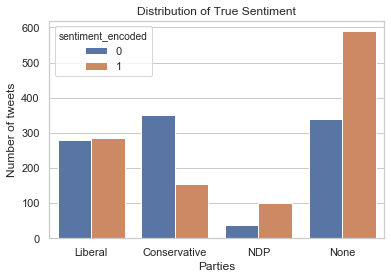

In [184]:
# Create a bar plot that illustrates the distribution of true sentiment for each party:
sns.set(style="whitegrid")
ax = sns.countplot(x='Parties', hue="sentiment_encoded", data=elections_df, order=['Liberal','Conservative','NDP','None'])
ax.set(xlabel='Parties', ylabel='Number of tweets', title='Distribution of True Sentiment')

[Text(0, 0.5, 'Number of tweets'),
 Text(0.5, 0, 'Parties'),
 Text(0.5, 1.0, 'Distribution of Predicted Sentiment')]

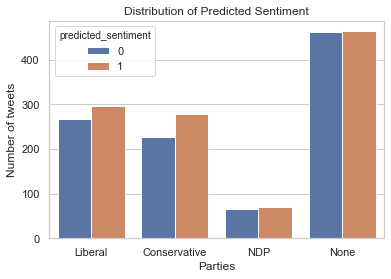

In [185]:
# Create a bar plot that illustrates the distribution of predicted sentiment for each party:
sns.set(style="whitegrid")
ax = sns.countplot(x='Parties', hue="predicted_sentiment", data=elections_df, order=['Liberal','Conservative','NDP','None'])
ax.set(xlabel='Parties', ylabel='Number of tweets', title='Distribution of Predicted Sentiment')

Comparing the above two distributions of true sentiment and predicted sentiment, the prediction results are not very satisfying. The logistic regression has failed to differentiate postive and negative sentiment for each of the three parties. Positive predictions for the Liberal, the NDP, and None are close to their true values. However, the Conservative sees 50% more predicted positive than true positive. In terms of predicting negative sentiment, we see significant difference between the predictions and the true values for the Conservatie, the NDP and None. The Conservative received more negative tweets than positive tweets in reality, but the prediction has failed to capture that and shows more positive than negative tweets for the Conservative. 

When we exclude predictions for the None and only look at the Liberal, the Conservative and the NDP, the Liberal is the party with the most tweets and the most positive tweets. This is consistent with the fact that the Liberal won the most seats in the House and the Liberal leader, Justin Treadue, was election as the Prime Minister. The Conservative has slightly less tweets and slightly less positive tweets according to the prediction. This observation agrees with the fact that the Conservative has the second highest seats in the House, only after the Liberal. The NDP received significantly less tweets comparing to the other two. It is consistent with the fact that the NDP lost 11 seats to the Liberal and the Conservative after the election. 

To conclude, NLP and sentiment analysis can actually reveal some general trend in public opinion, although not to an extent that can provide accurate and precise insight. For example, NLP has failed to reveal that the public has a negative attitude towards the Conservative. It is a piece of important information for developing their campaign strategies. 

Split the negative 2019 Canadian elections tweets into training data (70%) and test data (30%). Use the sentiment labels in the 2019 Canadian elections data instead of your predictions from the previous part. Choose three algorithms from classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost)), train multi-class classification models to predict the reason for the negative tweets. There are 10 different negative reasons labelled in the dataset. Feel free to combine similar reasons into fewer categories as long as you justify your reasoning. You are free to define input features of your model using word frequency analysis or other techniques.

In [186]:
# Select negative 2019 Canadian elections tweets:
elections_negative = elections_df[elections_df['sentiment']=='Negative']
elections_negative.head()

,sentiment,negative_reason,text,text_clean,Parties,predicted_sentiment,sentiment_encoded
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead agree canadian women trust...,Conservative,0,0
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...,Liberal,0,0
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",taxpayers sick tired hard earned corporate nee...,Liberal,1,0
5,Negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...",canadavotes facts conservatives end long gun e...,Conservative,1,0
8,Negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...",chooseforward ncanada make america mistakes fu...,Liberal,1,0


In [189]:
# Check what are the negative reasons:
elections_negative['negative_reason'].unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Tell lies', 'Privilege', 'Climate Problem',
       'Healthcare', 'Separation', 'Healthcare and Marijuana'],
      dtype=object)

Here we gourp together 'Scandal' and 'Tell lies' as they're both scandals essentially. We also group together 'Healthcare' and 'Healthcare and Marijuana' as they're both related to the healthcare industry in Canada. 

In [200]:
# Group similar reasons:
reasons = {   'Women Reproductive right and Racism': 'Women Reproductive right and Racism',
    'Economy': 'Economy',
    'Others': 'Others', 
    'Scandal': 'Scandal',
    'Tell lies': 'Scandal',
    'Privilege': 'Privilege', 
    'Climate Problem': 'Climate Problem',
    'Healthcare': 'Healthcare',
    'Healthcare and Marijuana': 'Healthcare', 
    'Separation': 'Separation' }

In [201]:
# Map the grouping to the original data:
elections_negative.loc[1:,'negative_reason'] = elections_negative.loc[1:,'negative_reason'].map(reasons)
elections_negative.negative_reason.unique()

array(['Women Reproductive right and Racism', 'Economy', 'Others',
       'Scandal', 'Privilege', 'Climate Problem', 'Healthcare',
       'Separation'], dtype=object)

In [202]:
# Encode negative reasons:
reasons_encode = {   'Women Reproductive right and Racism': 0,
    'Economy': 1,
    'Scandal': 2, 
    'Tell lies':2,
    'Privilege': 3,
    'Climate Problem': 4,
    'Healthcare': 5, 
    'Healthcare and Marijuana': 5,
    'Separation': 6, 
    'Others': 7 }

In [203]:
# Label Encoding the target variable, negative reason:
elections_negative.loc[1:,'negative_reason_encoded'] = elections_negative.loc[1:,'negative_reason'].map(reasons_encode)
elections_negative.loc[1:,'negative_reason_encoded'] = elections_negative.loc[1:,'negative_reason_encoded'].astype(int)
elections_negative.negative_reason_encoded.unique()

array([nan,  1.,  7.,  2.,  3.,  4.,  5.,  0.,  6.])

In [207]:
# There is one missing value, drop the nan:
elections_negative = elections_negative.dropna(subset=['negative_reason_encoded'])

In [210]:
elections_negative.head()

,sentiment,negative_reason,text,text_clean,Parties,predicted_sentiment,sentiment_encoded,negative_reason_encoded
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ju...,Liberal,0,0,1.0
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",taxpayers sick tired hard earned corporate nee...,Liberal,1,0,1.0
5,Negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...",canadavotes facts conservatives end long gun e...,Conservative,1,0,3.0
8,Negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...",chooseforward ncanada make america mistakes fu...,Liberal,1,0,3.0
9,Negative,Scandal,"b""#CPCKinsellaGate\nLet's see the receipts. Wh...",cpckinsellagate nlet see pays warren kinsella ...,Liberal,0,0,5.0


In [209]:
# Define target variable:
y = elections_negative['negative_reason_encoded']

Here we choose TF-IDF to generate features

In [211]:
# Create TF-IDF for the negative election tweets dataset:
vectorizer4 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
array_TFIDF4 = vectorizer4.fit_transform(elections_negative['text_clean']).toarray()
array_TFIDF4.shape

(1005, 1706)

In [212]:
# Store the word frequency in a dataframe:
# Each column of the dataframe represents one feature for machine learning:
X = pd.DataFrame(data=array_TFIDF4, columns=vectorizer4.get_feature_names())
X.head()

,ab,abc,able,ableg,abortion,abpoli,absolute,absolutely,abuse,accept,...,yesterday,yet,yfblanchet,ygk,young,yqg,yrs,yup,yyc,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [213]:
# Train test split negative election tweets (30% testing data):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2)

Model 1: Logistic Regression

In [217]:
# Create logistic regression model:
model_lr1 = LogisticRegression(penalty = 'l1', C = 1, solver = 'saga', max_iter = 5000, multi_class = 'ovr')
model_lr1.fit(X_train, y_train)

# Predict target vector
pred_lr1 = model_lr1.predict(X_test)

In [218]:
print("Accuracy: ", accuracy_score(y_test, pred_lr1))

Accuracy:  0.5529801324503312


Model 2: Multinomial Naive Bayes

In [220]:
# Create Multinominal Naive Bayes model:
model_mnb1 = MultinomialNB()
model_mnb1.fit(X_train, y_train)

# Predict target vector
pred_mnb1 = model_mnb1.predict(X_test)

In [221]:
print("Accuracy: ", accuracy_score(y_test, pred_mnb1))

Accuracy:  0.44370860927152317


In [ ]:
elections_negative['predicted_reason'] = pred_mnb1
elections_negative.head()

Model 3: Support Vector Machine

In [222]:
# Create Linear Support Vector Classifier:
model_svm1 = LinearSVC(penalty = 'l2', loss = 'hinge', C = 1, multi_class = 'ovr', random_state=0, max_iter=2000)
model_svm1.fit(X_train, y_train)

# Predict target vector
pred_svm1 = model_svm1.predict(X_test)

In [225]:
print("Accuracy: ", accuracy_score(y_test, pred_svm1))

Accuracy:  0.5198675496688742


The accuracy of the three models on predicting negative reasons is summarized as follows:
<table>
    <thead>
        <tr>
            <th>Classification Models</th>
            <th>Accuracy</th>
        </tr>
    <thead>
    <tbody>
        <tr>
            <td>Logistic Regression</td>
            <td>0.553</td>
        </tr>
        <tr>
            <td>Multinomial Naive Bayes</td>
            <td>0.444</td>
        </tr>
        <tr>
            <td>Support Vector Machine</td>
            <td>0.520</td>
        </tr>
    </tbody>
</table>

### 5. Results

Answer the research question stated above based on the outputs of your first model. Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value. For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets. For both models, suggest one way you can improve the accuracy of your models.

The research question proposed at the beginning of the report is: “What can public opinion on Twitter tell us about the Canadian political landscape in 2019?” We can answer this question based on the sentiment results of the logistic regression model. During the 2019 Canadian election, the Liberal and the Conservative are the two parties that received the most attention and discussion on Twitter. The NDP, however, received significantly less discussion compared to the other two. It can conclude that overall, the Liberal had a neutral image in the public eye. Amounts of positive comments on the Liberal were just slight more than the amount of negative comments. For the Conservative, the predictions show that it also had a neutral image in the public eye. There is no significant gap between the amount of positive and negative comments on Twitter about the Conservative. However, this prediction is quite opposite to the truth. According to the true sentiment, the Conservative was viewed rather negatively in the public eye and received much more negative tweets than positive ones on Twitter. As for the NDP, it also had a neutral image in the public eye according to the predictions. Again, that does not perfectly align with the truth. The true sentiment shows that the NDP was viewed quite positive by the public.

There are many ways to improve the accuracy of the logistic regression model. For this particular dataset, accuracy can be improved if more training data is selected or better features are included. Running machine learning models on high dimensional text data tends to be computational expansive, thus, after removing stopwords, we ranked all the remaining words based on frequency and kept the top 20 to 2000 words in the dataset. It serves as a feature selection technique and has significantly reduced the number of features for machine learning models. However, this feature selection approach, unlike correlation analysis or Lasso, cannot guarantee to capture all important features, which contributes to the lower accuracy level of the logistic regression model. Higher accuracy can be achieved by having a more suitable feature selection technique such as word embedding.

In terms of predicting negative reasons for negative tweets, the logistic regression model has higher accuracy (55.3%) comparing to the Multinominal Naive Bayes model (44.4%) and the Support Vector Machine model (52%). Similar to the previous task which is predicting sentiment, the accuracy of the logistic regression model can be improved by having a more robust feature selection technique such as word embedding such that all important features can be captured and passed to the logistic regression model. On the other hand, logistic regression classifiers are linear classifiers, however, for this particular application, the relationship between the features (words) and the target variable (negative reason) may not be described using a linear function. Thus, logistic regression model might not be the most suitable model to perform this type of classification. Models that can handle nonlinearity such as neural network classifiers will perform better here.